<a href="https://colab.research.google.com/github/NSR9/PythonForML-AI-Notes/blob/master/s5/s5_itr1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!





# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
# set the dropout value
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()


     # Conv Block1
      self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)) # output_size = 26

    # Conv Block2 
      self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) # output_size = 24  



    # Conv Block3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(1,1), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(32),
          nn.Dropout(dropout_value)) # output_size = 24


    # TRANSITION BLOCK 1
      self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12


    # Conv Block4
      self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = (1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32)) # output_size = 12


    # Conv Block5
      self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) # output_size = 12


    # Conv Block6
      self.convblock6 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) #output_size = 10


    # Conv Block7
      self.convblock7 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels=10, kernel_size =(1,1), padding =0, bias=False)) # output_size = 1
      

    # Output Block
      self.gap = nn.Sequential(nn.AvgPool2d(8)) # Global Average Pooling


    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.pool1(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.gap(x)
      x = self.convblock7(x)
      
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)


  

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 32, 24, 24]             512
              ReLU-8           [-1, 32, 24, 24]               0
       BatchNorm2d-9           [-1, 32, 24, 24]              64
          Dropout-10           [-1, 32, 24, 24]               0
        MaxPool2d-11           [-1, 32, 12, 12]               0
           Conv2d-12           [-1, 32, 12, 12]           1,024
             ReLU-13           [-1, 32, 12, 12]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
# Optimization and Testing
from torch.optim.lr_scheduler import StepLR


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


for epoch in range(1, 16):
    print('EPOCH: ',epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.22192718088626862 Batch_id=468 Accuracy=76.65: 100%|██████████| 469/469 [00:10<00:00, 46.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2562, Accuracy: 9392/10000 (93.92%)

EPOCH:  2


Loss=0.16852323710918427 Batch_id=468 Accuracy=95.39: 100%|██████████| 469/469 [00:09<00:00, 47.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1446, Accuracy: 9640/10000 (96.40%)

EPOCH:  3


Loss=0.06860846281051636 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:09<00:00, 49.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1009, Accuracy: 9745/10000 (97.45%)

EPOCH:  4


Loss=0.10423749685287476 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:09<00:00, 48.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0969, Accuracy: 9758/10000 (97.58%)

EPOCH:  5


Loss=0.13180860877037048 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:09<00:00, 47.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 9757/10000 (97.57%)

EPOCH:  6


Loss=0.07896421104669571 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:09<00:00, 48.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1013, Accuracy: 9719/10000 (97.19%)

EPOCH:  7


Loss=0.07853492349386215 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:09<00:00, 48.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 9816/10000 (98.16%)

EPOCH:  8


Loss=0.04922136664390564 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:09<00:00, 48.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0634, Accuracy: 9832/10000 (98.32%)

EPOCH:  9


Loss=0.053326692432165146 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:09<00:00, 47.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0567, Accuracy: 9841/10000 (98.41%)

EPOCH:  10


Loss=0.03726932406425476 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:09<00:00, 49.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9843/10000 (98.43%)

EPOCH:  11


Loss=0.049508411437273026 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:09<00:00, 47.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9834/10000 (98.34%)

EPOCH:  12


Loss=0.028699079528450966 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:09<00:00, 48.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0563, Accuracy: 9831/10000 (98.31%)

EPOCH:  13


Loss=0.1033034548163414 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:09<00:00, 50.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9837/10000 (98.37%)

EPOCH:  14


Loss=0.021432489156723022 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:09<00:00, 49.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0519, Accuracy: 9837/10000 (98.37%)

EPOCH:  15


Loss=0.10242395848035812 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:09<00:00, 48.10it/s]



Test set: Average loss: 0.0531, Accuracy: 9830/10000 (98.30%)



Text(0.5, 1.0, 'Test Accuracy')

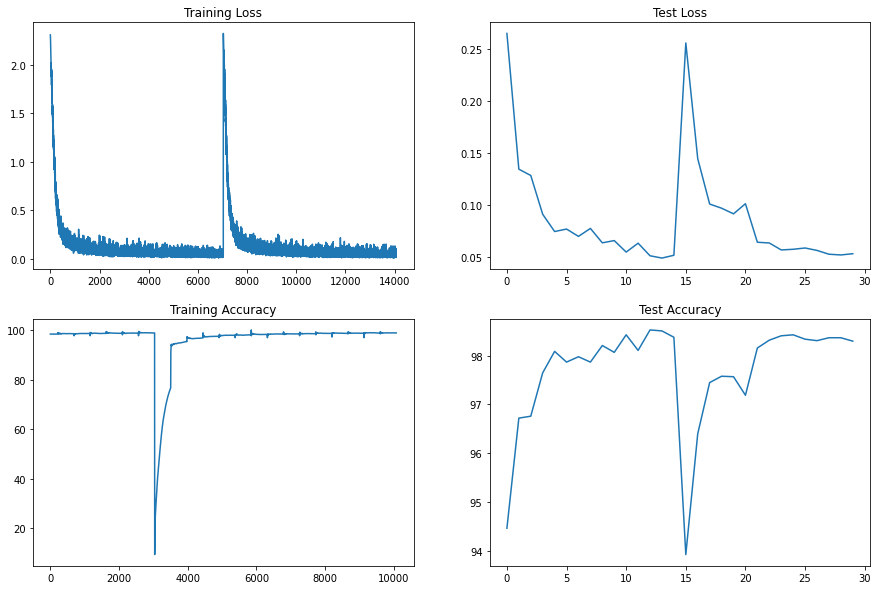

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")